In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns

In [2]:
import warnings

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
start_date = "2022-07-01T00"
end_date = "2022-07-31T00"

dates = pd.date_range(
    start_date,
    end_date,
    freq="3h",
)

In [5]:
varlist = [
    "tmp",
    "ugrd",
    "vgrd",
    "dzdt",
    "spfh",
    "tmp2m",
    "pressfc",
    "ugrd10m",
    "vgrd10m",
    "geopotential",
    # additions 
    "spfh2m",
    "albdo_ave",
    "sltyp",
    "vtype",
    "tmpsfc",
]

In [6]:
ufs2era = {
    "tmp": "temperature",
    "ugrd": "u_component_of_wind",
    "vgrd": "v_component_of_wind",
    "dzdt": "vertical_velocity",
    "spfh": "specific_humidity",
    "tmp2m": "2m_temperature",
    "pressfc": "surface_pressure",
    "ugrd10m": "10m_u_component_of_wind",
    "vgrd10m": "10m_v_component_of_wind",
    "geopotential": "geopotential",
    "prateb_ave": "total_precipitation",
    "vtype": "soil_type",
    "albdo_ave": None,
    "sltyp": None,
    "spfh2m": None,
    "tmpsfc": None,
}

In [7]:
selected_levels = (676, 773, 1000)

Replay

In [6]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [9]:
rds = rds[varlist]
rds = rds.sel(time=dates)
rds = rds.sel(pfull=list(selected_levels), method="nearest")

In [10]:
%%time
rds = rds.load()

CPU times: user 1min 21s, sys: 1min 3s, total: 2min 24s
Wall time: 1min 6s


In [7]:
rds

<xarray.Dataset> Size: 60TB
Dimensions:        (time: 87020, grid_yt: 192, grid_xt: 384, pfull: 127)
Coordinates:
    cftime         (time) object 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
  * grid_xt        (grid_xt) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * grid_yt        (grid_yt) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
  * pfull          (pfull) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 696kB 1993-12-31T18:00:00 ... 2023-1...
Data variables: (12/183)
    acond          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    albdo_ave      (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnsf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnwf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvsf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvwf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ...             ...
    xtts           (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xu             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xv             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xz             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xzts           (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    zc             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
Attributes:
    abstract:         The NOAA Unified Forecast System (UFS) / Global Ensembl...
    acknowledgement:  To provide appropriate attribution under this license, ...
    description:      This zarr store is a subset of the original GEFSv13 UFS...
    license:          The Global Ensemble Forecast System version 13 (GEFSv13...

In [12]:
rds = rds.rename({
    "grid_yt": "lat",
    "grid_xt": "lon",
    "pfull": "level",
})

ERA5

In [13]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era[[ufs2era[v] for v in varlist if ufs2era[v] is not None]].sel(
    time=dates,
    level=list(selected_levels), method="nearest",
).rename({
    "latitude": "lat",
    "longitude": "lon",
})
era = era.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))

In [14]:
%%time
era = era.load()

CPU times: user 3min 59s, sys: 3min 8s, total: 7min 8s
Wall time: 5min 2s


In [15]:
era.attrs["label"] = "ERA5"
rds.attrs["label"] = "Replay"

Normalization

In [16]:
norm = {
    k: xr.open_zarr(
        f"gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.statistics.1993-2019/{k}_by_level.zarr",
        storage_options={"token": "anon"},
    ).rename({
        "pfull": "level",
    }).load()
    for k in ["mean", "stddev", "diffs_stddev"]
}

In [17]:
def plot_col(ax, xdalist, level, show_nnz, do_diff, do_log, quickplot):
    warnings.filterwarnings("error")
    thedata = {}
    for xda, label in zip(
        xdalist,
        ["Replay", "ERA5"],
    ):
        gkey = xdalist[0].name
        if len(xdalist) > 1:
            ekey = xdalist[1].name
        else:
            ekey = gkey
        local = xda.sel(level=level, method="nearest", drop=True).copy() if level is not None else xda.copy()
        if quickplot:
            lonidx = np.random.randint(low=0, high=len(local.lon), size=(50,))
            latidx = np.random.randint(low=0, high=len(local.lat), size=(50,))
            local = local.isel(lon=lonidx,lat=latidx)
        if xdalist[0].name == "tmp":
            local -= 273.15
        if do_log:
            transform = np.log if do_diff else np.log10
            cond = local > 0.
            thresh_transform = lambda x: xr.where(cond, transform(x.where(cond)), 0.)
            try:
                local = thresh_transform(local)
            except RuntimeWarning:
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    local = thresh_transform(local)

                msg = f"Trouble running np.log on {label} {gkey}"
                if level is not None:
                    msg += f" level {level}"
                print(msg)
                pass
                
        if do_diff:
            local = local.diff("time")

        # normalization, only for do_diff
        localnorm = 1
        localloc = 0
        if do_diff:
            if not do_log:
                localnorm = norm["diffs_stddev"][gkey]
            elif f"log_{gkey}" in norm["diffs_stddev"]:
                localnorm = norm["diffs_stddev"][f"log_{gkey}"]

        if isinstance(localnorm, xr.DataArray):
            if level is not None:
                localnorm = localnorm.sel(level=level, method="nearest", drop=True)
            localnorm = localnorm.values

        if np.isnan(local).any().values:
            msg = f"Found NaNs in {label} {gkey}"
            if level is not None:
                msg += f" level {level}"
            print(msg)

        thedata[label] = local.values.flatten() / localnorm
        
    sns.violinplot(
        thedata,
        ax=ax,
        cut=0,
    )
    title = " ".join([x.capitalize() for x in ekey.split("_")])
    if do_log:
        title = f"log({title})" if do_diff else f"log10({title})"
        
    if do_diff:
        title = f"diff({title})\n/std(diff({title}))"
    ax.set(title=title if ax.get_subplotspec().is_first_row() else "")
    if show_nnz:
        ax.axhline(y=0, color="gray", alpha=.5)
        negative = {key: np.sum(val < 0) for key, val in thedata.items()}
        ax.set(
            xticks=ax.get_xticks(),
            xticklabels = [f"{key}\n({val})" for key,val in negative.items()],
        )


In [18]:
def histplot(gkeylist, levels=selected_levels, do_diff=False, sharey=False, logvars=tuple(), show_nnz_vars=tuple(), quickplot=False):

    ncols = len(gkeylist)
    nrows = len(levels) if "level" in rds[gkeylist[0]].dims else 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*4), constrained_layout=True, sharey=sharey, sharex=True)
    
    for gkey, axc in zip(gkeylist, axs.T):
        ekey = ufs2era[gkey]
        xdalist = [rds[gkey], era[ekey]] if ekey is not None else [rds[gkey]]
        do_log = gkey in logvars
        show_nnz = gkey in show_nnz_vars
        
        kw = {"show_nnz": show_nnz, "do_diff": do_diff, "do_log": do_log, "quickplot": quickplot}
        
        if "level" in rds[gkey].dims:
            if nrows == 1:
                axc = [axc]
            for level, ax in zip(levels, axc):
                plot_col(ax, xdalist, level=level, **kw)
                ax.set(
                    ylabel=f"~{int(level)} hPa" if ax.get_subplotspec().is_first_col() else "",
                )
        else:
            plot_col(axc, xdalist, level=None, **kw)
    return fig, axs

In [19]:
vars2d = [v for v in varlist if "level" not in rds[v].dims]
vars3d = [v for v in varlist if "level" in rds[v].dims]

## 2D Fields

In [22]:
vars2d

['tmp2m',
 'pressfc',
 'ugrd10m',
 'vgrd10m',
 'spfh2m',
 'albdo_ave',
 'sltyp',
 'vtype',
 'tmpsfc']

In [23]:
targets2d = ["pressfc", "tmpsfc", "tmp2m", "spfh2m", "ugrd10m", "vgrd10m"]

In [30]:
fig_dir = "figures/variable-distributions"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

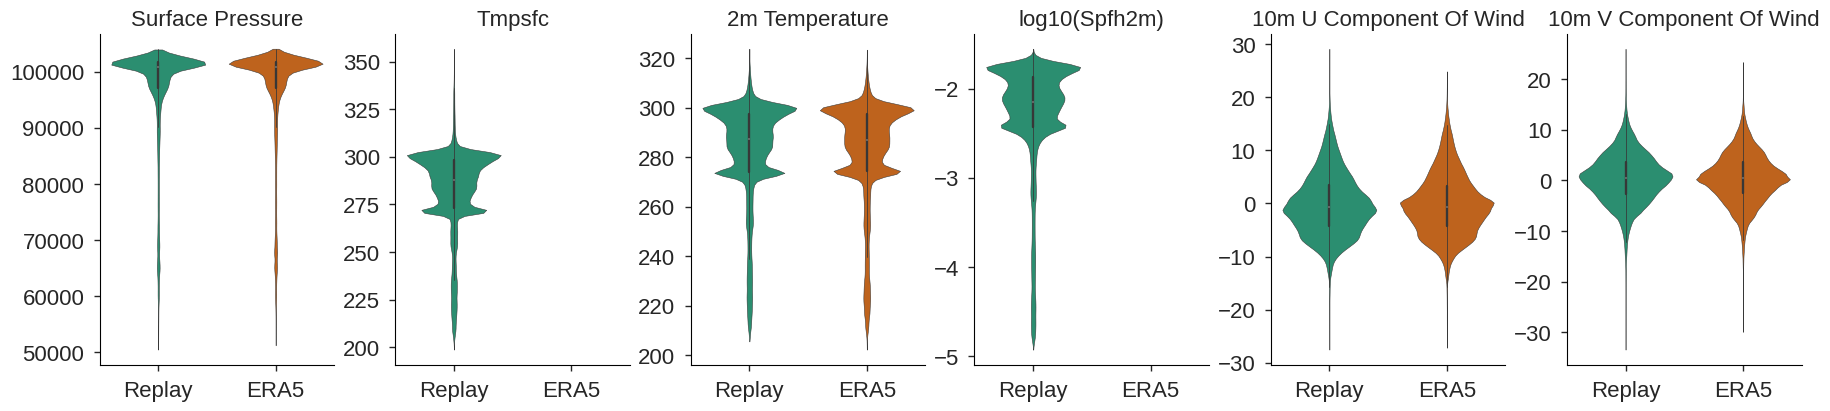

In [32]:
fig, axs = histplot(targets2d, logvars=("spfh2m",));
fig.savefig(f"{fig_dir}/surface.jpeg", bbox_inches="tight", dpi=300)

CPU times: user 1min 13s, sys: 367 ms, total: 1min 14s
Wall time: 42.8 s


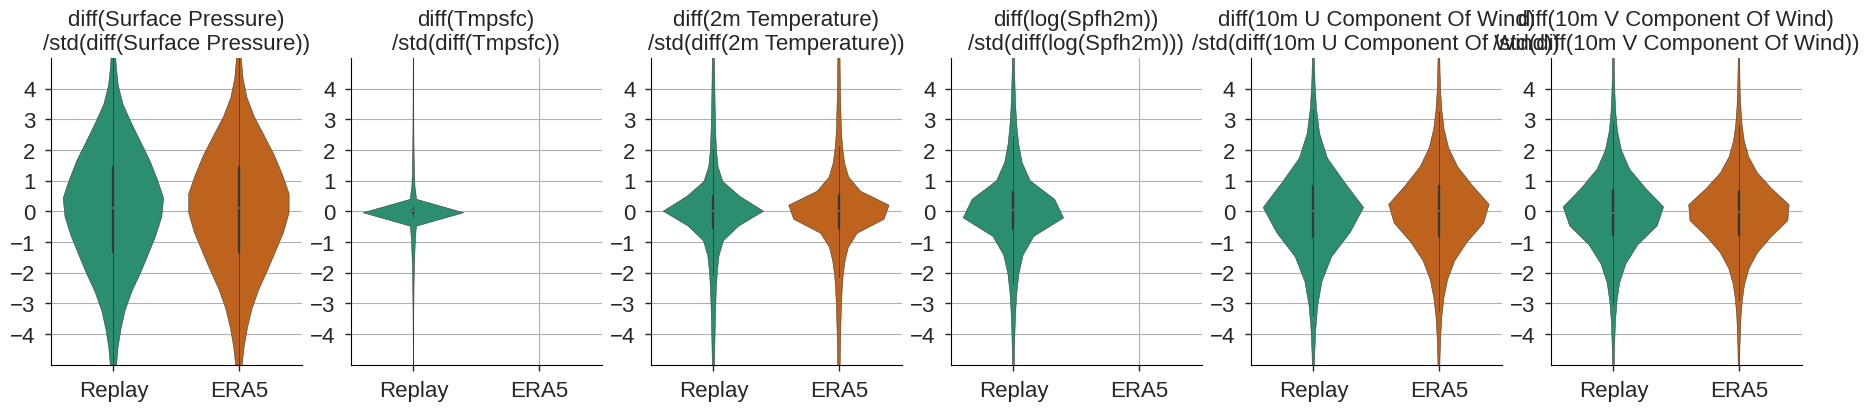

In [33]:
%%time
fig, axs = histplot(targets2d, do_diff=True, logvars=["spfh2m"]);
for v, ax in zip(targets2d, axs):
    ax.set(
        ylim=(-5, 5),
        yticks=np.arange(-4,5),
    )
    ax.grid(visible=True);

fig.savefig(f"{fig_dir}/surface_diff.jpeg", bbox_inches="tight", dpi=300)

## 3D Fields

In [20]:
vars3d = ["geopotential", "tmp", "spfh", "ugrd", "vgrd", "dzdt"]

In [22]:
%%time
fig, axs = histplot(vars3d, logvars=("spfh"));
#fig.savefig(f"{fig_dir}/levels.jpeg", bbox_inches="tight", dpi=300)


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7ef94c634360> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x7ef919489a80> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



CPU times: user 57min 46s, sys: 1min 36s, total: 59min 23s
Wall time: 37min 23s


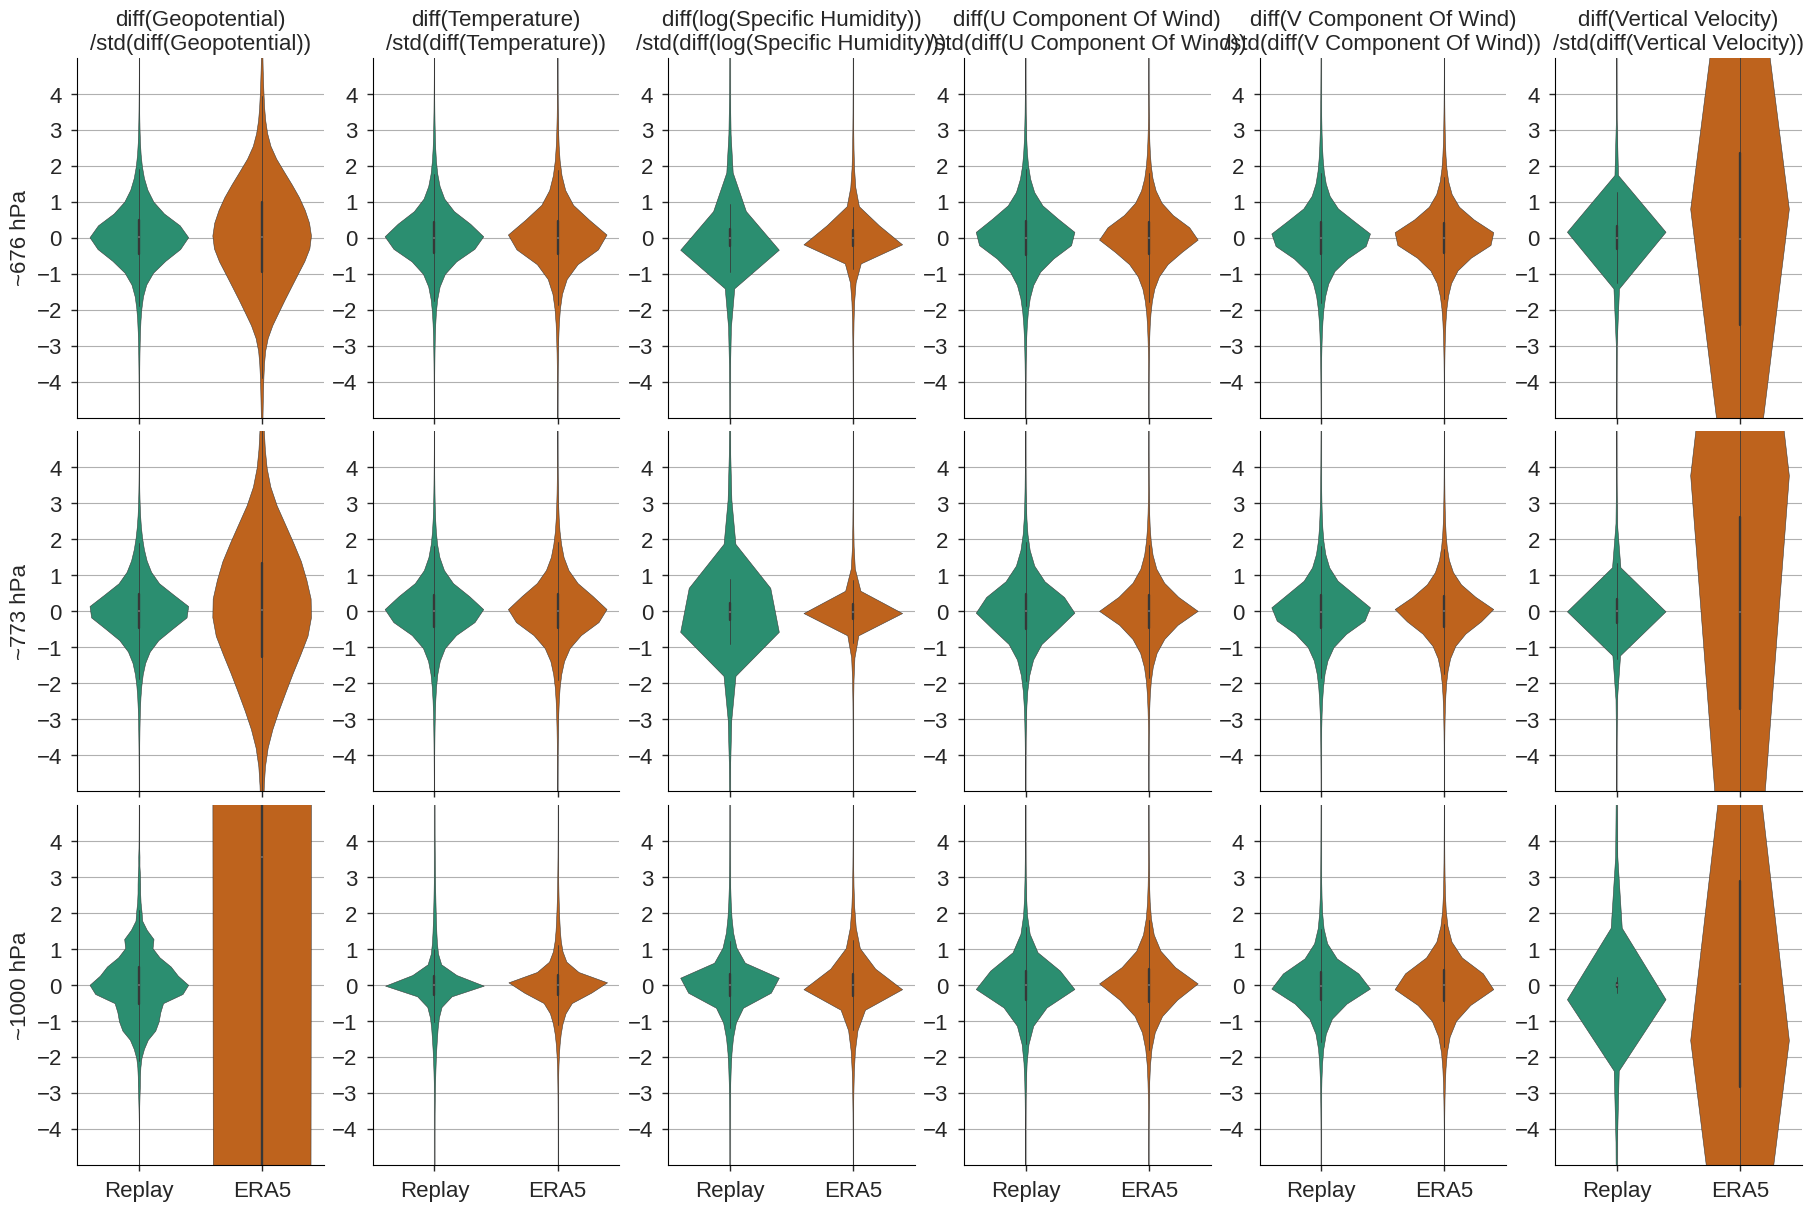

In [23]:
%%time
fig, axs = histplot(vars3d, do_diff=True, logvars=("spfh"));
for ax in axs.flatten():
    ax.set(
        ylim=(-5, 5),
        yticks=np.arange(-4,5),
    )
    ax.grid(visible=True);
#fig.savefig(f"{fig_dir}/levels_diff.jpeg", bbox_inches="tight", dpi=300)